<a href="https://colab.research.google.com/github/tutsilianna/Introduction_to_ML_and_Advanced_ML_Python/blob/main/Clustering/Clustering_1_%7C_Exercise_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering using the `K-means` method to select groups of objects

In this task, we will consider the <code>K-means</code> clustering method to solve the clustering problem itself - the problem of selecting similar structures in data. We will work with the well-known <a href="http://yann.lecun.com/exdb/mnist/"><code>MNIST</code></a> dataset.

Let's load the dataset. We will use only the test part of the original set to reduce the training time of the models.

In [80]:
from keras.datasets import mnist
import warnings
warnings.filterwarnings("ignore")

(_,_), (X, y) = mnist.load_data()

An example of outputting multiple objects and the corresponding class labels:

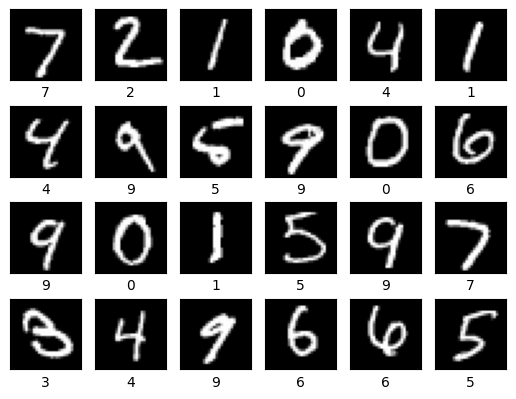

In [81]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(X[i], cmap='gray')
    axi.set(xticks=[], yticks=[])
    axi.set_xlabel(y[i],
                   color='black')

Enter the <code>.shape</code> of the resulting dataset

In [82]:
X.shape

(10000, 28, 28)

Split the dataset into training and test samples using <code>train_test_split</code> with parameters `test_size=0.2, random_state=35`.

In [83]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35)

Since we are talking about a known dataset, let's make <code>K-means</code> search for $10$ groups of objects.

"Straighten" the images and train the algorithm <a href="https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html"><code>KMeans</code></a> on the training dataset with the parameters `random_state=35`, `n_clusters=10`.

In [84]:
X_train = X_train.reshape(len(X_train), -1)
X_train.shape

(8000, 784)

In [85]:
from sklearn.cluster import KMeans

kmeans = KMeans(random_state=35, n_clusters=10).fit(X_train)

Determine the number of elements assigned to the cluster labeled 6.

In [86]:
kmeans.labels_.tolist().count(6)

959

Construct images corresponding to centroids of the obtained clusters. To do this, `reshape` coordinates of centroids to the size $28 \times 28$ and build the resulting matrix, for example, in black and white shades.

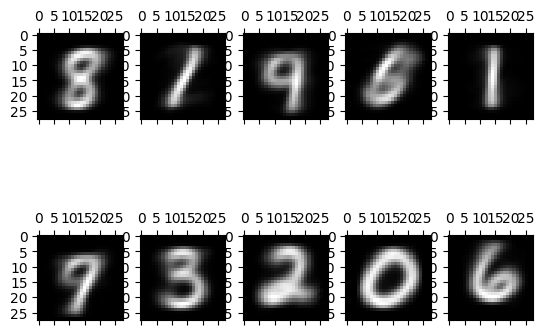

In [87]:
import numpy as np

centroids = kmeans.cluster_centers_

images = centroids.reshape(10, 28, 28)

_,axs = plt.subplots(2, 5)
for i in range(2):
    for j in range(5):
        ax = axs[i,j]
        cnt = (i*5+j)
        ax.matshow(images[cnt], cmap="gray")

It can be seen that the resulting pictures look very similar to handwritten digits. However, the clustering was not without problems. Assume which digits may be mixed up and which digits are missing.

Since the resulting clusters know nothing about the nature of the objects being clustered, the labels of the clusters may differ from the "reasonable labels". Reconstruct the correct labels using the following considerations: a cluster is assigned the label of those digits whose representatives are the majority in the cluster. Did it really help to restore fairness?

Enter the obtained cluster labels after transformation via comma and space and compare with previously constructed images based on centroids. Are your assumptions confirmed by facts?

In [88]:
labels = kmeans.labels_
new_labels = []
for i in range(10):
    digit_counts = np.bincount(y_train[labels == i])
    new_labels.append(np.argmax(digit_counts))
new_labels = np.array(new_labels)

In [89]:
new_labels

array([8, 1, 4, 5, 1, 7, 3, 2, 0, 6])

It is reasonable to estimate something like accuracy. Assuming that all objects in the cluster have the same label as the cluster itself, compare these labels to the true labels. Calculate <code>accuracy</code> for the training dataset. We recommend using the function <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html"><code>accuracy_score</code></a> from the <code>sklearn</code> library.

In [90]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """

    inferred_labels = {}

    for i in range(kmeans.n_clusters):

        # find index of points in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]

        #print(labels)
        #print('Cluster: {}, label: {}'.format(i, np.argmax(counts)))

    return inferred_labels

def infer_data_labels(X_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """

    # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)

    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key

    return predicted_labels

In [91]:
cluster_labels = infer_cluster_labels(kmeans, y_train)
X_clusters = kmeans.predict(X_train)
predicted_labels = infer_data_labels(X_clusters, cluster_labels)

In [92]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_train, predicted_labels)

round(accuracy, 3)

0.609

Use the <code>.predict()</code> method to cluster the test dataset. Rename the labels of the predicted clusters based on the transformation obtained for the training dataset.

In [93]:
X_test = X_test.reshape(len(X_test), -1)

In [94]:
test_clusters = kmeans.predict(X_test)

predicted_labels = infer_data_labels(test_clusters, cluster_labels)

accuracy = accuracy_score(y_test, predicted_labels)

round(accuracy, 3)

0.599

Construct the confusion matrix.

In [95]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predicted_labels)

print('Confusion Matrix:\n', cm)

Confusion Matrix:
 [[148   0   1  12   0  33   5   0   1   0]
 [  0 208   0   1   0   0   1   0   0   0]
 [  1  30 140  10   8   6   2   4   4   0]
 [  0   7  10 143   2  13   1   0  28   0]
 [  0  10   0   0 113  16   5  55   1   0]
 [  0   8   0  65   7  55   1   8  43   0]
 [  4   4   1   0   3  53 130   1   3   0]
 [  0  15   1   0  59   0   0 125   1   0]
 [  2  11   0  25   6  18   0   4 136   0]
 [  1   5   1   0 102   1   1  77   4   0]]


With which digit did the trained model most often confuse the digit 9 on the test dataset?

In [96]:
# Находим цифру, с которой модель чаще всего путала цифру 9
most_confused_digit = np.argmax(cm[9])

print('The model most often confused the digit 9 with the digit:', most_confused_digit)

The model most often confused the digit 9 with the digit: 4


Evaluate model on the test dataset.

In [97]:
# < ENTER YOUR CODE HERE >

It is interesting to note that we built the classifier based on clustering while we did not use any "correct answers" (except for evaluation).

How many clusters seems to be the optimal number of clusters when using the Elbow method? Consider the number of clusters from $7$ to $16$. Can you confidently determine the optimal number of clusters?

In [98]:
# < ENTER YOUR CODE HERE >

All this training is too long. Let's make a "horseplay" and lower the dimensionality of the data, trying to keep distances between objects. Let's see how this affects speed and accuracy.

Transform the <b>training dataset</b> using the method <a href="https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html"><code>TSNE</code></a> from the <code>sklearn</code> library with the parameters `n_components=2, init='random', random_state=35`.

In [103]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='random', random_state=35)
X_train_tsne = tsne.fit_transform(X_train)

Cluster the resulting dataset using <code>KMeans</code> with the parameters `n_clusters=10, random_state=35`. Similar to what was done before, reassign cluster labels based on the labels of most objects within the cluster. Evaluate the accuracy of the model on the <b>training dataset</b>.

In [104]:
kmeans_tsne = KMeans(n_clusters=10, random_state=35).fit(X_train_tsne)

In [106]:
cluster_labels_tsne = infer_cluster_labels(kmeans_tsne, y_train)
X_clusters_tsne = kmeans_tsne.predict(X_train_tsne)
predicted_labels_tsne = infer_data_labels(X_clusters_tsne, cluster_labels_tsne)

In [107]:
accuracy = accuracy_score(y_train, predicted_labels_tsne)

round(accuracy, 3)

0.82

The problem, however, is known. `t-SNE` is a method that does not give a rule for obtaining projections of a multidimensional space onto, for example, a two-dimensional space. Thus, when new data appears, the projections will have to be searched again.

At the same time, once again, we would like to emphasize how unsupervised learning has allowed the construction of a classifier that seems to be the result of solving the problem of supervised learning.